In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

### Rent & Buy Price Values

In [37]:
def process_prices(city, state, geography, inputFile, outputFile):
    inputFile = inputFile.replace('{geography}', geography)
    outputFile = outputFile.replace('{geography}', geography)
    df = pd.read_csv(inputFile)
    df = df[df.Metro.str.contains(city, case=False, na=False)]
    df = df[df.State.str.contains(state, case=False, na=False)]
    df = df.rename(index=str, columns={'RegionName':geography, 'City':'city','State':'state','Metro':'metro','CountyName':'county'})
    df.reset_index(drop=True, inplace=True)
    df.drop(['SizeRank'], axis=1, inplace=True)
    df.to_csv(outputFile, index=False)

In [38]:
city = 'miami'
state = 'FL'
# Make directory to store clean dataframes
if not os.path.exists(city):
    os.makedirs(city)

In [39]:
rent_files = [
    'datasets/{geography}_MedianRentalPrice_1Bedroom.csv',
    'datasets/{geography}_MedianRentalPricePerSqft_1Bedroom.csv',
    
    'datasets/{geography}_MedianListingPrice_AllHomes.csv',
    'datasets/{geography}_MedianListingPricePerSqft_AllHomes.csv',

    'datasets/{geography}_MedianRentalPrice_2Bedroom.csv',
    'datasets/{geography}_MedianRentalPricePerSqft_2Bedroom.csv',
    
    'datasets/{geography}_MedianRentalPrice_Sfr.csv',
    'datasets/{geography}_MedianRentalPricePerSqft_Sfr.csv',
    
    'datasets/{geography}_PriceToRentRatio_AllHomes.csv'
]
output_rent_files = [
    city + '/{geography}_rent_1BR_total.csv',
    city + '/{geography}_rent_1BR_sqft.csv',

    city + '/{geography}_buy_home.csv',
    city + '/{geography}_buy_home_sqft.csv',
    
    city + '/{geography}_rent_2BR_total.csv',
    city + '/{geography}_rent_2BR_sqft.csv',
    
    city + '/{geography}_rent_SF_total.csv',
    city + '/{geography}_rent_SF_sqft.csv',
    
    city + '/{geography}_price_rent_ratio.csv'
]

### Indicators

In [40]:
indicator_files = [
    'datasets/Affordability_Income_2017Q4.csv',
    'datasets/Affordability_Wide_2017Q4_Public.csv',
    'datasets/BreakEven_PR_2018-032.csv',
    'datasets/home_forecast.csv',
    'datasets/rent_forecast.csv'
]
output_indicator_files = [
    city + '/indicators_affordability_income.csv',
    city + '/indicators_affordability_wide.csv',
    city + '/indicators_breakeven_rate.csv',
    city + '/indicators_home_forecast.csv',
    city + '/indicators_rent_forecast.csv'
]

In [47]:
def process_indicators(cities, states, inputFile, outputFile):
    df = pd.read_csv(inputFile)
    df = df[df.RegionName.str.contains('|'.join(cities), case=False, na=False)]
    df = df.rename(index=str, columns={'RegionID':'zipcode','RegionName':'city'})
    df.reset_index(drop=True, inplace=True)
    df.to_csv(outputFile, index=False)

In [48]:
cities = ['miami','seattle']
states = ['FL','WA']
geographies = ['Zip','Neighborhood']

In [49]:
def processDatasets():
    # process geographies
    for geography in geographies:
        for i in range(0,len(rent_files)):
            process_prices(city, state, geography, rent_files[i], output_rent_files[i])
    # process indicators
    for i in range(0,len(indicator_files)):
        process_indicators(cities, states, indicator_files[i], output_indicator_files[i])

In [50]:
processDatasets()

## Clean

In [51]:
price_files = {
    '{geography}_rent_1BR_total':'rent_1br_monthly',
    '{geography}_rent_2BR_sqft':'rent_2br_sqft',
    '{geography}_rent_2BR_total':'rent_2br_monthly',
    '{geography}_rent_SF_sqft':'rent_sf_sqft',
    '{geography}_rent_SF_total':'rent_sf_monthly',
    '{geography}_buy_home': 'buy_home',
    '{geography}_buy_home_sqft':'buy_home_sqft',
    '{geography}_price_rent_ratio':'price_rent_ratio'
}

### Rent & Home Data Issues
1. Drop historical data, leave just last value
2. Add column to identify value (price_rent, price_rent_sqrt)
3. Combine values in single dataset

In [53]:
def cleanPriceFile(file, geography, indicator):
    file = file.replace('{geography}', geography)
    df = pd.read_csv(city + '/' + file + '.csv')
    if 'RegionID' in df.columns:
        df = df.drop(['RegionID'],axis=1)
    df_clean = df.iloc[:,:5]
    # grab the latest price column as indicator
    df_clean[indicator] = df.iloc[:,-1:]
    return df_clean

In [58]:
def cleanPriceDatasets(geography):
    df = cleanPriceFile('{geography}_rent_1BR_sqft', geography, 'rent_1br_sqft')
    for k, v in price_files.items():
        df_n = cleanPriceFile(k, geography, v)
        df = df.merge(df_n, how='outer',on=[geography,'city','state','metro','county'])
#         df['zipcode'] = df['zipcode'].astype(int)
    print('storing ' + geography)
    df.to_csv(city + '_' + geography + '_prices_clean.csv', index=False)

In [59]:
for geography in geographies:
    cleanPriceDatasets(geography)

storing Zip
storing Neighborhood


In [60]:
# breakeven data
df = pd.read_csv('miami/indicators_breakeven_rate.csv')
df = df[df.StateName.str.contains('|'.join(['FL']), case=False, na=False)]
df = df.drop(['RegionType','SizeRank','City','BEPropCount','SampleRate','Breakeven','MedPR'],axis=1)
df = df.rename(index=str, columns={'MedBE':'breakeven_years','StateName':'state','Metro':'metro','CountyName':'county'})
df.to_csv(city + '_breakeven_clean.csv', index=False)

### Visualize - Indicators

In [61]:
def plot_indicators(df, indicators, column_start, nIndicators, firstCity, secondCity):
    for i in range(len(indicators)):
        fig, ax = plt.subplots()
        l = i*nIndicators
        m = i*nIndicators+1
        ax.plot(df.iloc[l,column_start:],'b--', label=firstCity)
        ax.plot(df.iloc[m,column_start:],'g:', label=secondCity)
        plt.title(indicators[i])
        plt.legend()

#### Income

In [62]:
df = pd.read_csv('miami/indicators_affordability_income.csv')

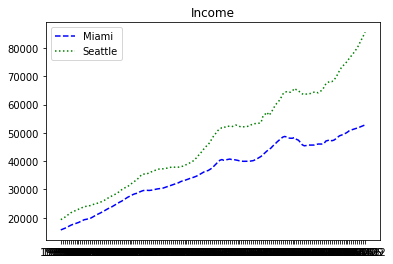

In [63]:
indicators = ['Income']
plot_indicators(df, indicators, 3, 1, 'Miami','Seattle')

#### Affordability Wide

In [64]:
df = pd.read_csv('miami/indicators_affordability_wide.csv')

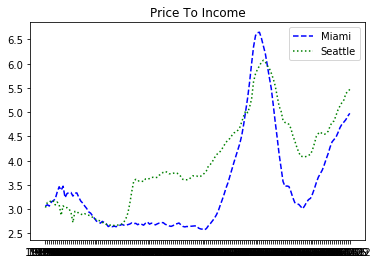

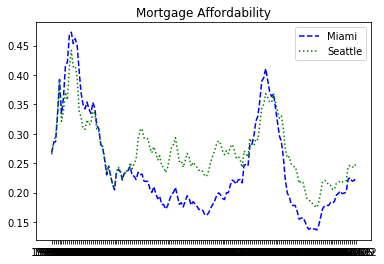

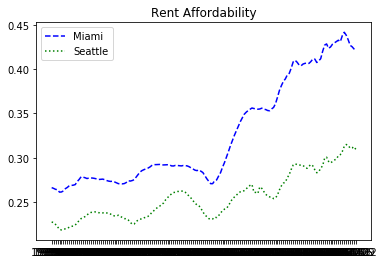

In [65]:
affordability_indicators = [
    'Price To Income',
    'Mortgage Affordability',
    'Rent Affordability'
]
plot_indicators(df, affordability_indicators, 5, 2, 'Miami','Seattle')

In [66]:
df = pd.read_csv('miami/indicators_home_forecast.csv')
df = df[df.State.str.contains('|'.join(['FL','WA']), case=False, na=False)]
df = df.drop(['Region','MSAName','CountyName','CityName'],axis=1)
df = df.rename(index=str, columns={'ForecastYoYPctChange':'forecast_change'})
df

,city,State,forecast_change
0,"Miami-Fort Lauderdale, FL",FL,3.795636
1,"Seattle, WA",WA,7.644874
4,Miami-Dade,FL,3.175798
5,Miami Beach,FL,-1.755131
6,Miami Lakes,FL,3.168426
7,South Miami,FL,2.442290
8,West Miami,FL,4.592217
9,Miami,FL,3.081885
10,Seattle,WA,8.406685
11,Miami Shores,FL,2.299885


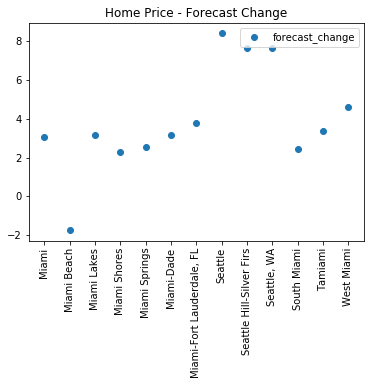

In [67]:
plt.scatter(df.city, df.forecast_change)
plt.title('Home Price - Forecast Change')
plt.legend()
_ = plt.xticks(rotation=90)

In [68]:
df = pd.read_csv('miami/indicators_rent_forecast.csv')
# df = df[df.State.str.contains('|'.join(['FL','WA']), case=False, na=False)]
df = df.drop(['RegionType','SizeRank','ZriForecast'],axis=1)
df = df.rename(index=str, columns={'Forecast_YoY_Change':'rent_forecast_change','Current_YoY_Change':'rent_current_change'})
df

,zipcode,city,rent_forecast_change,rent_current_change
0,394856,"Miami-Fort Lauderdale, FL",0.024129,0.010840
1,395078,"Seattle, WA",0.047101,0.047438


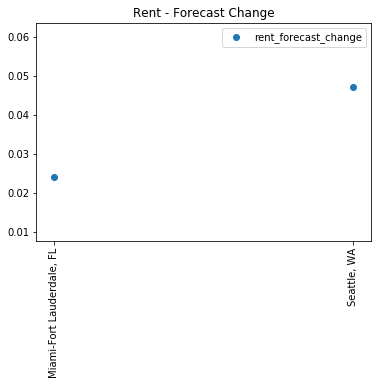

In [69]:
plt.scatter(df.city, df.rent_forecast_change)
plt.title('Rent - Forecast Change')
plt.legend()
_ = plt.xticks(rotation=90)

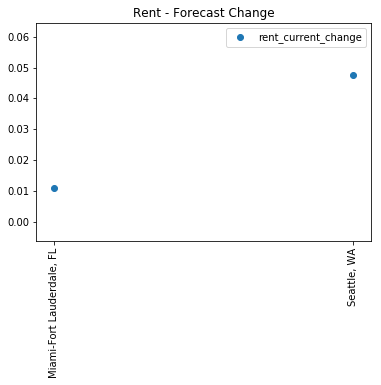

In [70]:
plt.scatter(df.city, df.rent_current_change)
plt.title('Rent - Forecast Change')
plt.legend()
_ = plt.xticks(rotation=90)

## Consumer Price Index

In [45]:
df = pd.read_csv('cpi/seattle.csv')

In [64]:
df['sea_index_dec_2017'] = df['sea_index_dec_2017'].astype(float)
df['item'] = df['item'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 6 columns):
item                  57 non-null category
sea_index_dec_2017    57 non-null float64
sea_index_feb_2018    57 non-null float64
mia_index_dec_2017    57 non-null float64
mia_index_feb_2018    57 non-null float64
diff_dec_2017         57 non-null float64
dtypes: category(1), float64(5)
memory usage: 5.3 KB


In [79]:
df['diff_dec_2017'] = df['sea_index_dec_2017'] - df['mia_index_dec_2017']
df['diff_index_feb_2018'] = df['sea_index_feb_2018'] - df['mia_index_feb_2018']

In [80]:
df

,item,sea_index_dec_2017,sea_index_feb_2018,mia_index_dec_2017,mia_index_feb_2018,diff_dec_2017,diff_index_feb_2018
0,All items,265.85,268.03,258.24,264.99,7.61,3.04
1,All items (1967=100),810.41,817.06,416.24,427.13,394.17,389.93
2,Food and beverages,265.97,266.61,262.83,261.15,3.14,5.46
3,Food,268.57,269.19,264.86,263.62,3.71,5.57
4,Food at home,248.17,248.61,255.01,252.88,-6.84,-4.27
5,Cereals and bakery products,282.71,280.17,271.32,273.68,11.39,6.49
6,"Meats, poultry, fish, and eggs",207.65,203.23,247.80,237.27,-40.15,-34.04
7,Dairy and related products,217.02,219.33,219.60,221.07,-2.58,-1.74
8,Fruits and vegetables,402.99,400.63,338.32,347.16,64.67,53.47
9,Nonalcoholic beverages and beverage materials(1),279.25,298.94,252.06,247.35,27.19,51.59
